# Analysing data with Python and MNE

Sebo Uithol, PhD, June 2023

Welcome to the practical session EEG data analysis! This practical session is part of the course Experimentation II at Leiden University. In this session we will study the EEG signals during an Eriksen Flankers Task. We will get acquainted with the typical preprocessing steps, the analysis of the data and the interpretation of the results.

The data that we will be analysing was recorded at Leiden University, with the same equipment that we've used during the data acquisition practical.

The data was acquired during an Eriksen flankers task. This is a conflict task that belongs to the same family of paradigms as the Stroop and Simon task. Participants are instructed to respond as fast as possible to the direction of the central stimulus in an array like this by pressing a response button with the corresponding index finger (in this case the right index finger).

![title](flankers.jpg)

Flanking stimuli around the target are irrelevant, but can prime the correct response (congruent), or the opposite response (incongruent). Immediately after stimulus presentation, the attentional spotlight (the area of stimulus information that is selected for further processing) has not yet been narrowed, so the dominant information derives from the flankers, which may point at the wrong response. As the spotlight is narrowed, the support for the correct response increases. In the ERP you are likely to see initial signs of motor preparation for the hand indicated by the flankers (LRP) and signs of error detection processes (ERN). In addition, the ERP will show large components such as the P300. Prior to the P300, there is a weak negative component that is sensitive to the presence of conflict in the decision processes (N200). We will see to what extent these waves can be identified and quantified. Some of these ERP peaks will be analysed in the following.




### Importing
Now it is time to start our python script. Before we can start loading the data, we need to have the proper tools in place. Obviously we need to import MNE. Next we import matplotlib, for data visualisation, pandas for data analysis, and numpy for working with data structures. If you don't like typing the same words over and over again, you can import libraries as a shorter name, for instance 'pandas' as 'pd'. This saves time later on, but it is optional.

In [1]:
import mne
import matplotlib
import pandas as pd
import numpy as np


### Creating paths
Next we will set up the folders, so that python knows where to look for what. Type in the path corresponding to the location where you stored the data. To keep things need, we stored the eeg data file and the behavioural data file in two separate folders.


In [2]:
dataPath = '/Users/sebouithol/surfdrive/Leiden/Teaching/Experimentation II/Data Analysis Practical/dataEEG/'
dataPathBehav = '/Users/sebouithol/surfdrive/Leiden/Teaching/Experimentation II/Data Analysis Practical/dataBehavioural/'




### Loading the data
Now we want to create an array with the content of the eeg data file. We do this using the command read_raw_bdf. This command is part of the MNE toolbox, and within MNE of the io (input-output)library, so the full command will read as: nameArray = mne.io.read_raw()

We need to specify the filename within the brackets. For this we also make use of the path that we created above.

In [14]:
filename = "Flanker_EEG_52_12052022.bdf"
fullFileName = (dataPath + filename)

raw_eeg = mne.io.read_raw_bdf(fullFileName, preload=True)

Extracting EDF parameters from /Users/sebouithol/surfdrive/Leiden/Teaching/Experimentation II/Data Analysis Practical/dataEEG/Flanker_EEG_52_12052022.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1778175  =      0.000 ...  3472.998 secs...


We want to know what kind of data we have imported, so we use the command type:

In [4]:
raw_eeg.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 72 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2022-05-12 14:32:28 UTC
 nchan: 73
 projs: []
 sfreq: 512.0 Hz
>

We will also have to specify what the locations of each of the electrodes is. Luckily we do not have to do this by hand. MNE has atlasses of standard systems. Ours is called biosemi64. If we use this, the location of each of the electrodes is provided. Additionally, we will specify that EXG1 through EXG6 are used to track eye movements (eog channels).

In [15]:
biosemi_montage = mne.channels.make_standard_montage("biosemi64")
raw_eeg.set_montage(biosemi_montage, on_missing='ignore')
raw_eeg.set_channel_types(
    {'EXG1': 'eog', 'EXG2': 'eog', 'EXG3': 'eog', 'EXG4': 'eog', 'EXG5': 'eog', 'EXG6': 'eog'})
raw_eeg.drop_channels(['EXG7', 'EXG8'])  # Unused channels

<RawEDF | Flanker_EEG_52_12052022.bdf, 71 x 1778176 (3473.0 s), ~963.3 MB, data loaded>

# Preprocessing
EEG preprocessing encompasses multiple steps. Generally, these steps are different in every experiment, as they are dependent on the research question, the recording setup, and the subsequent analysis steps. So there is no one-size-fits-all method. The steps below are common in many analysis pipelines.

### Downsampling
In the output above we can find all kinds of characteristics of the data file. For instance, you can see that 72 electrodes have been used. That the recording took almost an hour, and that the analogue signal was sampled with a 512Hz frequency. For our purpose this is a bit too high, which will make files unnecessarily big, and computations slow. So we will downsample the data. This will be done using the resample command. We will have to specify the sfreq for this. You can add this in the code below. Use a value of 250.

In [16]:
raw_eeg = raw_eeg.resample(sfreq=250)

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
2823 events found
Event IDs: [    4     8    16    33    34    35    36 65536 65789]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
2823 events found
Event IDs: [    4     8    16    33    34    35    36 65536 65789]


If you want to check whether it was successful you can use the following command.

In [17]:
raw_eeg.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 1 Stimulus
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2022-05-12 14:32:28 UTC
 nchan: 71
 projs: []
 sfreq: 250.0 Hz
>

### Rereferencing
You may remember from the lecture that the potential that is recorded at each electrode is not an absolute value, but always a difference between that electrode and another electrode. You may also remember that during the acquisition we have placed two electrodes on the mastoids. We will set the average of these two channels as explicit reference for all the other electrodes.


In [18]:
raw_eeg.set_eeg_reference(ref_channels=['EXG5', 'EXG6'])  # Take average of mastoids as reference


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEDF | Flanker_EEG_52_12052022.bdf, 71 x 868250 (3473.0 s), ~470.4 MB, data loaded>

Now let's have a quick inspection of what the raw data looks like.

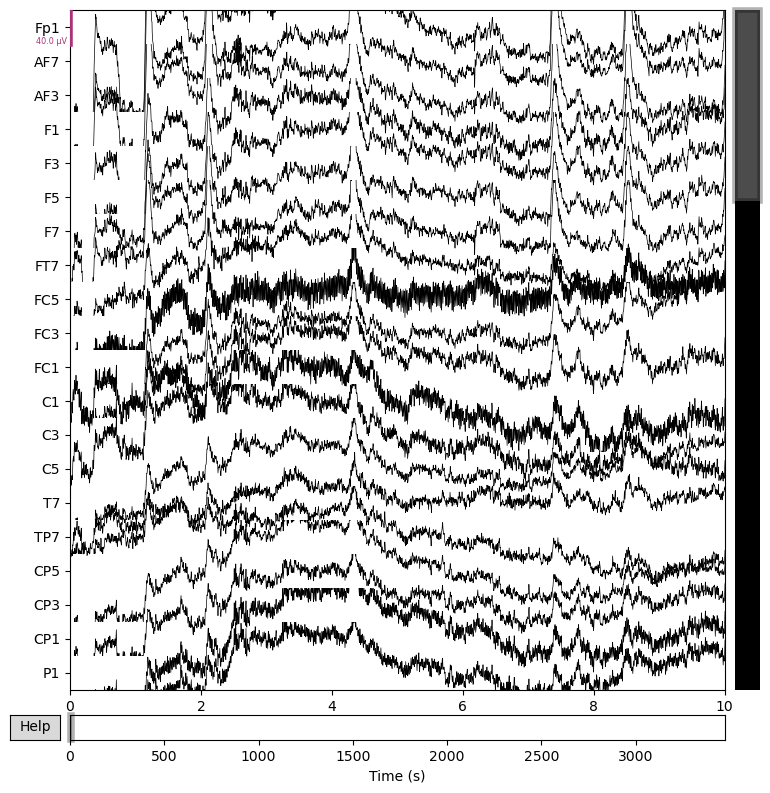

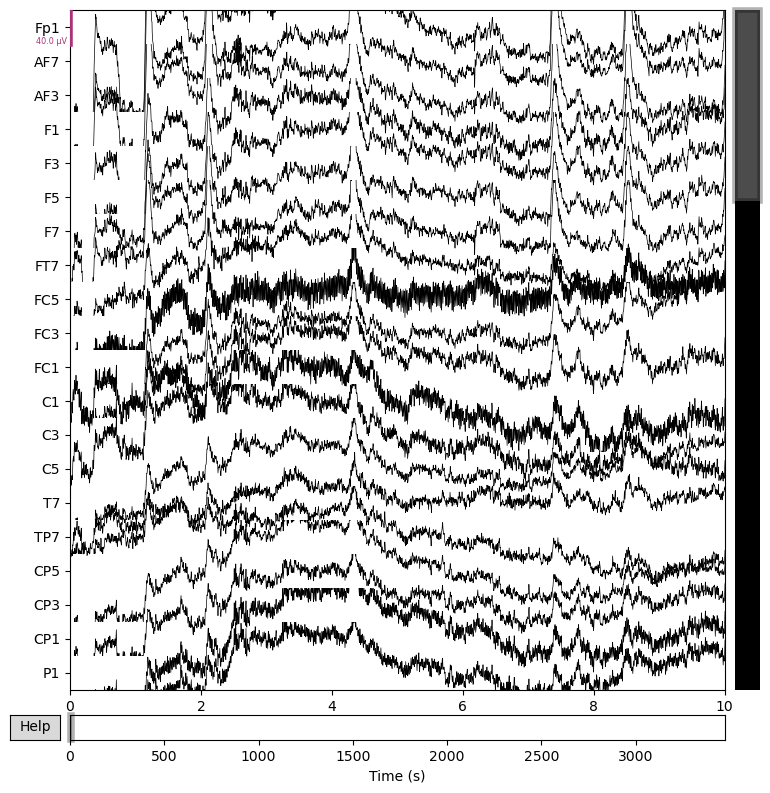

In [19]:
mne.viz.plot_raw(raw_eeg)

Ok, it is clearly data, but it does not look pretty. It still contains various types of noise. In different steps we will remove different types of noise.

### Filtering
The EEG signal can be constructed as an assembly of sinus waves of different frequencies, phase, and strength (a Fourrier Analysis). Of some of these frequencies, the very low  and very high ones, we can be sure that they do not correlate to brain activity. Low frequencies may be attributed to amplifier drift, or sweat. We use a so-called _high-pass_ filter to discard this frequencies High pass means that frequencies higher than a certain threshold can 'pass' the filters; lower frequencies are filtered out.
Higher frequencies we filter out using a _low-pass filter_. There is some controversy around the sourse of high frequencies in the EEG signal. We are certain that line noise (50Hz in Europe) and muscle activation contribute to this frequency range. But there seems to be evidence that higher frequencies can also originate from the brain. So you have to choose the threshold frequency of your low-pass filter wisely, dependent on your research question.

The names of the two filters always cause confusion. The value of a low-pass filter is always higher than that of a high-pass filter. Check whether you can explain why.

Here we will use a high pass setting of 0.1 Hz. This is relatively conservative filtering (everything slower than 10 second oscillations will be removed), but choose this setting because our independent component analysis will work better this way. We can of course choose to do another filterin after the ICA. If you try you will see that your data will look a lot better.

In [21]:
low_cut = 0.1
high_cut = 30
filtered_eeg = raw_eeg.copy().filter(low_cut, high_cut, fir_design='firwin')  # Filter between 1Hz and 30Hz


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.3s finished


Let's have a look at what the data looks like now. Use the same plot command as above, but this time plot the new array.

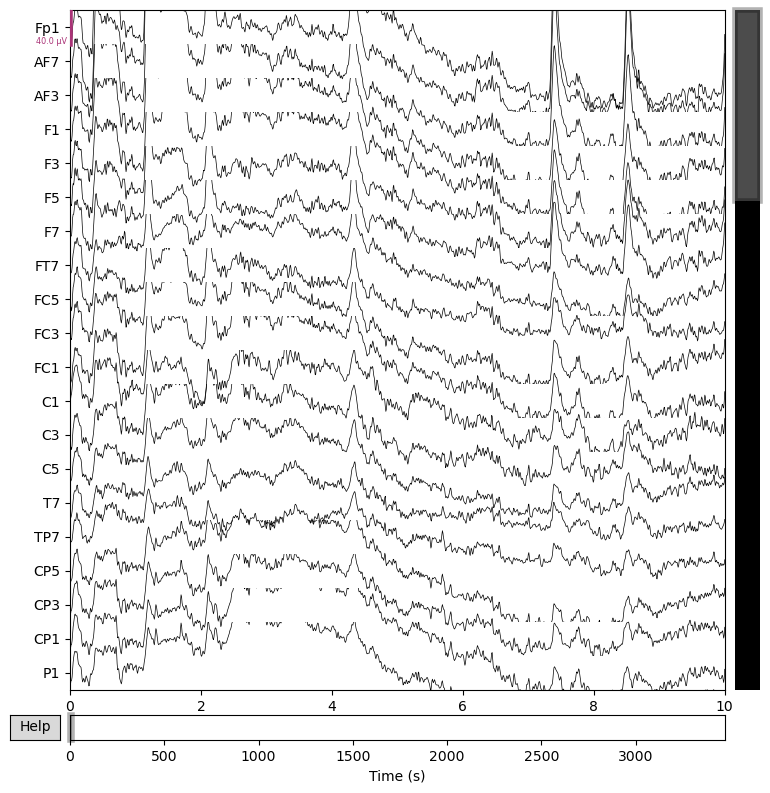

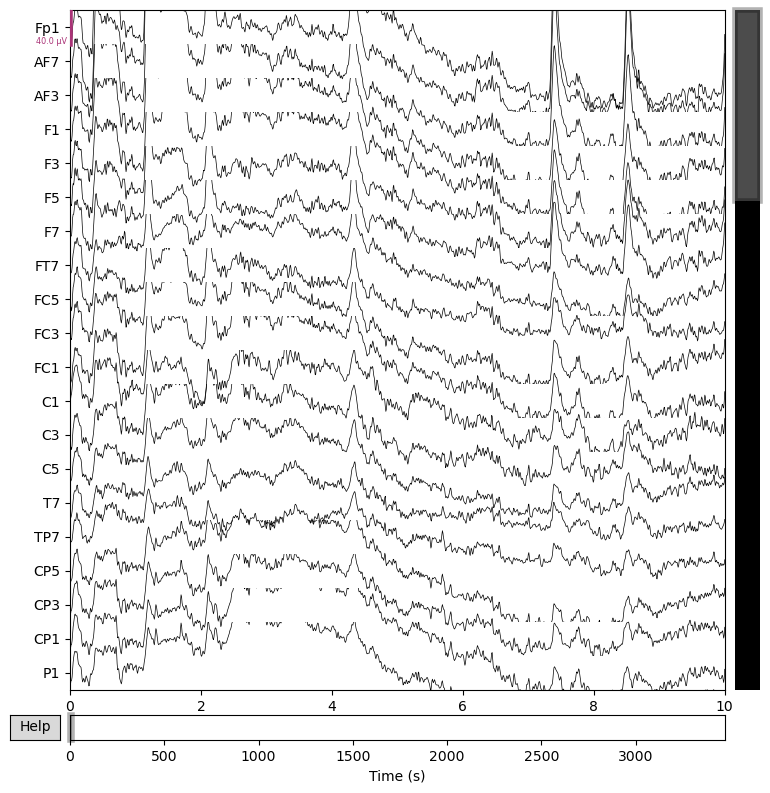

In [22]:
mne.viz.plot_raw(filtered_eeg)

This already looks a lot better, but we still need to remove the artifacts that originate from eye movements (blinks and saccades). For this it is best to cut the data in trials first.

In [23]:
from mne.preprocessing import ICA


method = 'picard'

n_components = 40 # select n_components by explained variance of PCA
random_state = 23 # Random seed

ica = ICA(n_components=n_components, method=method, random_state=random_state)
ica.fit(filtered_eeg, reject=None)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 40 components
Fitting ICA took 77.7s.


Method,picard
Fit,86 iterations on raw data (868250 samples)
ICA components,40
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Now let us plot these components for a visual inspection. The components are ranked ordinally, the first component explaining the most of the variance in the data, the last component the least.

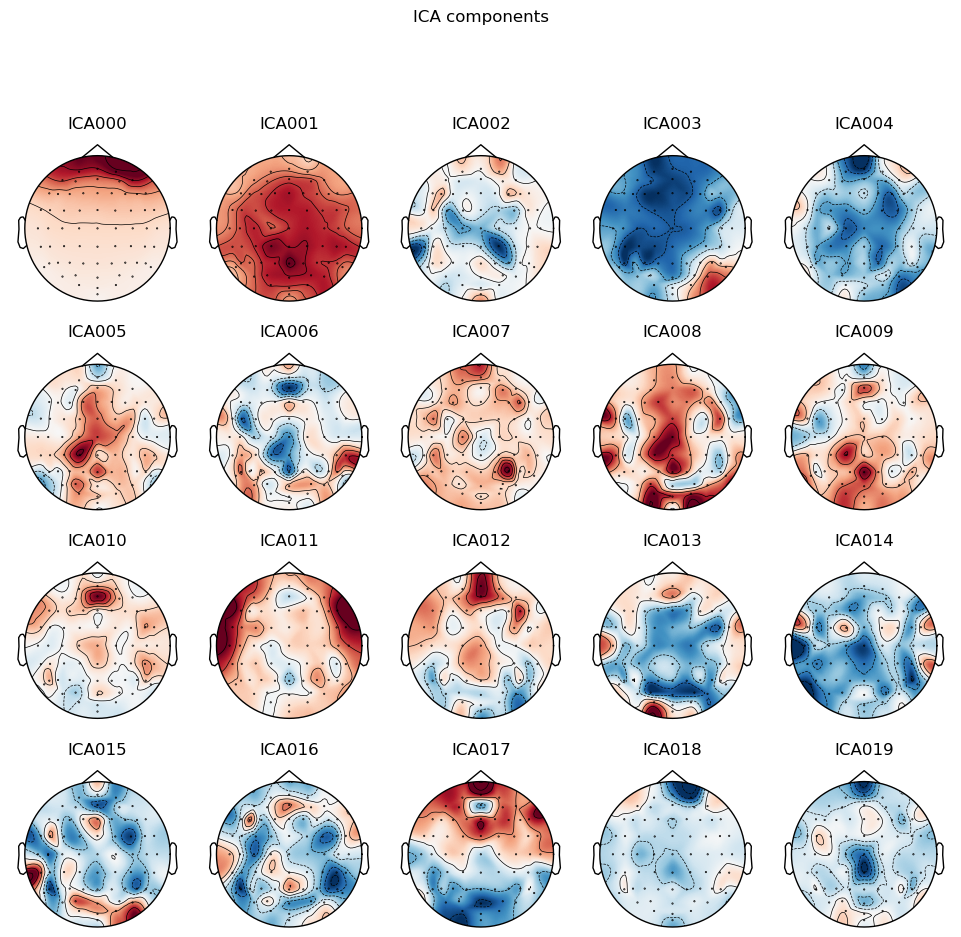

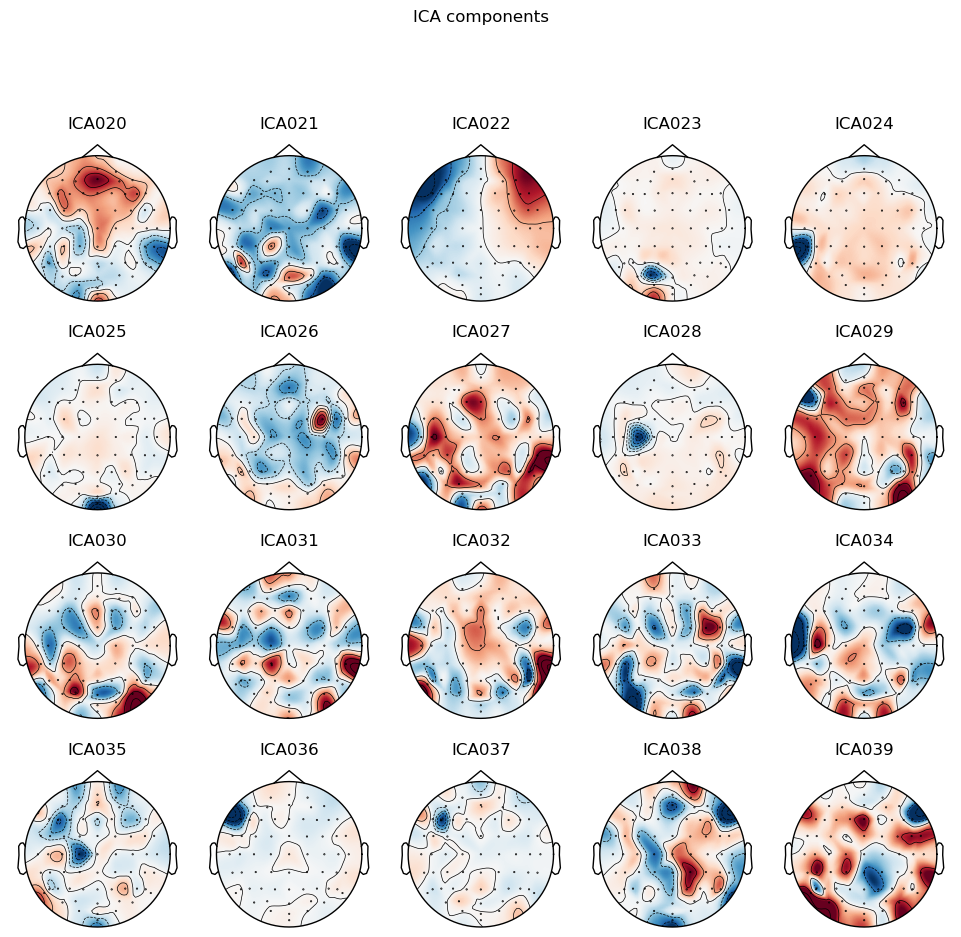

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x967 with 20 Axes>]

In [24]:
ica.plot_components()


What component correlates with eye blinks, you think? We will remove it from the data.

In [ ]:
ica.plot_sources(raw_eeg)

In [ ]:

ica = ICA(n_components=n_components, method=method, random_state=random_state)
picks = mne.pick_types(epochs.info, eeg=True, eog=False,
                       stim=False)

# Fit ICA on non-rejected epochs
#ica.fit(epochs[~reject_log.bad_epochs], picks=picks, reject=None)
ica.fit(epochs, picks=picks, reject=None)

ica.exclude = []

# Then, find which ICs match the EOG pattern and put them in ica.exclude
eog_indices, eog_scores = ica.find_bads_eog(epochs)
ica.exclude = eog_indices

# plot ICs applied to raw data, with ica.exclude highlighted. Check and see if I want to remove/add ICA's
ica_components_plot = ica.plot_components(title="ica components of rejected epochs")
ica_plot_sources = ica.plot_sources(epochs[~reject_log.bad_epochs], block=True)

# Finally, save and apply the ICA exclude to the data
ica.save(file_loc + f'EEG/ica_eog_solution_{locked}_{subj}-ica.fif', overwrite=True)
ica.apply(epochs, exclude=ica.exclude)

epochs.info['bads'] = [] # Make bads list empty again, we'll let autoreject handle this
epochs.save(file_loc + f'EEG/ica_cleaned_epochs_{locked}_{subj}-epo.fif', overwrite=True)
print(f"Saved ica-cleaned {locked} epochs")

### Loading the behavioural data

Because MNE is a python toolbox, the possibilities to combine eeg with behavioural data are unlimited. In this case, the behavioural data is stored in a separate text file.


In [ ]:
fileNameBehav = "flankertask_eyetracker_52_202205121431_format.txt"
fullFileNameBehav = dataPathBehav + fileNameBehav


# Load in behavioral data and make numpy array of trialtype
trials = pd.read_csv(fullFileNameBehav, sep=",")
trials['RT'].replace('None', np.nan, inplace=True)  # Replace "none" answers with "nan" for int processing
trials['RT'] = pd.to_numeric(trials['RT'], errors='coerce', downcast='integer')

trials['condition'] = trials['trialtype'] + ' ' + trials[
    'alert']  # Make condition column, with alert and trialtype
trials_num = trials[['condition']].to_numpy()

# Change coding of trialtype, and reshape to appropriate dimension for later processing
trials_num = np.where(trials_num == "congruent alert", 1, trials_num)
trials_num = np.where(trials_num == "congruent no_alert", 2, trials_num)
trials_num = np.where(trials_num == "incongruent alert", 3, trials_num)
trials_num = np.where(trials_num == "incongruent no_alert", 4, trials_num)
trials_num = np.where(trials_num == "catch alert", 5, trials_num)
trials_num = trials_num.reshape(720)

# Transfer the stimulus EEG triggers to an MNE event file
events = mne.find_events(raw_eeg, uint_cast=True, consecutive=False)

# Delete all markers except for "alert_onset" (34) --> we will use that to orient ourselves
# Note that there were also "alert_onset" triggers in no_alert trials, these were just silent
events_trials = mne.pick_events(events, exclude=[4, 8, 16, 33, 35, 36, 253])

# Merge trials_num and events_trials: replace third column np array with trials_num that contain trial condition
events_trials[:, 2] = trials_num

# alert-centered to flanker centered (+500)
events_trials[:, 0] = events_trials[:, 0] + (500 * (raw_eeg.info['sfreq'] / 1000))
# Dictionary of numbers
event_dict = {"congruent alert": 1, "congruent no_alert": 2,
              "incongruent alert": 3, "incongruent no_alert": 4,
              "catch alert": 5}

In [ ]:
tmin=-0.6
tmax = 0.7  # epoch from 0.6s before flanker onset to 0.7s after it

epochs = mne.Epochs(filtered_eeg, events_trials, event_dict, tmin, tmax, baseline=None,
                    metadata=trials, preload=True)

Now we can plot the epochs using the following command:

In [ ]:
mne.Epochs.plot(epochs)

### Artifact rejection
You may remember from the data acquisition practical that when the participant blinks, this will create big artifacts. So we want our software to detect eye blinks in the EOG channels, and correct the signal during those events. An independent component analysis (ICA) can do this for you.

#### Independent Component Anlysis
To understand an Independent Component Analysis (ICA), think of a number of musicians playing in a room, while being recorded by multiple microphones. Each microphone picks up the sound of all the musical instruments, but, importantly, at different strengths. An ICA is a mathematical procedure to re-construct the sound of each individual instrument based on the signals of each of the microphones. The number of instruments that can thus be isolated is limited by the number of microphones.
Back to EEG data preprocessing: The raw signal is composed of proper brain activation as well as artifacts such as eye-blinks and saccades. What we want to do is identify components that can be related to occular artifacts, and then subtract these components from the raw signal. What would be left is a signal that does not include the contribution of these noise components. Here the number of components that can be estimated is limited by the number of electrodes. Since this data was recorded using 64 channels, we have ample components at our disposal.

In [ ]:

from mne.preprocessing import ICA


method = 'fastica'

n_components = 40 # select n_components by explained variance of PCA
random_state = 23 # Random seed

ica = ICA(n_components=n_components, method=method, random_state=random_state)
picks = mne.pick_types(epochs.info, eeg=True, eog=False,
                       stim=False)

# Fit ICA on non-rejected epochs
#ica.fit(epochs[~reject_log.bad_epochs], picks=picks, reject=None)
ica.fit(epochs, picks=picks, reject=None)

ica.exclude = []

# Then, find which ICs match the EOG pattern and put them in ica.exclude
eog_indices, eog_scores = ica.find_bads_eog(epochs)
ica.exclude = eog_indices

# plot ICs applied to raw data, with ica.exclude highlighted. Check and see if I want to remove/add ICA's
ica_components_plot = ica.plot_components(title="ica components of rejected epochs")
ica_plot_sources = ica.plot_sources(epochs[~reject_log.bad_epochs], block=True)

# Finally, save and apply the ICA exclude to the data
ica.save(file_loc + f'EEG/ica_eog_solution_{locked}_{subj}-ica.fif', overwrite=True)
ica.apply(epochs, exclude=ica.exclude)

epochs.info['bads'] = [] # Make bads list empty again, we'll let autoreject handle this
epochs.save(file_loc + f'EEG/ica_cleaned_epochs_{locked}_{subj}-epo.fif', overwrite=True)
print(f"Saved ica-cleaned {locked} epochs")

We will have to indicate which channels will be used as reference. Let's use the average of the two mastoids for this

In [ ]:
raw.set_eeg_reference(ref_channels=['EXG5', 'EXG6']) # Take average of mastoids as reference

In [ ]:
biosemi_montage = mne.channels.make_standard_montage("biosemi16")
raw.set_montage(biosemi_montage, on_missing='ignore')
raw.set_channel_types({'EXG1': 'eog', 'EXG2': 'eog', 'EXG3': 'eog', 'EXG4': 'eog', 'EXG5': 'eog', 'EXG6': 'eog'})


Now let's plot the raw data for a quick visual inspection

In [ ]:
raw.plot()

You will see that after an initial period, EXG5 and EXG6 are almost a flat line, why is this the case? Why is it not a complete flat line?

In [ ]:
print(raw.info)

Probably depending on the screen, but it could be that the channel names  list has been truncated. When we are specifically interested in the channels we can use the ch_names command.

In [ ]:
print(raw.ch_names)

In [ ]:
montage=mne.channels.make_standard_montage('standard_1020')

In [ ]:
#numChan = 21
#for channel in range (0,numChan):

#mne.channels.get_builtin_montages()
#montage=mne.channels.make_standard_montage(kind="biosemi32")
raw.set_montage(montage); #on_missing='ignore'
#print(raw.ch_names)

In [ ]:
print(raw.ch_names)

In [ ]:
raw.plot_sensors(kind='3d', ch_type='eeg')

In [ ]:
raweeg.compute_psd(fmax=50).plot